## Предсказание вероятности поступления в университет по результатам экзаменов. 

В этой тетрадке я построю модель, прогнозирующую вероятность поступления абитуриента в университет на магистерскую программу на основании данных о результатах экзаменов и оценках поступающего, рейтинге университета, а также участии поступающего в исследовательской деятельности.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Описание данных.

Рассматриваемый датасет взят с [Kaggle](https://www.kaggle.com/mohansacharya/graduate-admissions). Набор данных является открытым (Лицензия [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)).

In [2]:
df = pd.read_csv('admissions.csv')

In [3]:
df.drop(columns = ['Serial No.'], inplace = True) # Столбец дублирует индекс

In [4]:
df.columns = ['GRE', 'TOEFL', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance of Admit']

In [5]:
df.head(10)

,GRE,TOEFL,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
5,330,115,5,4.5,3.0,9.34,1,0.90
6,321,109,3,3.0,4.0,8.20,1,0.75
7,308,101,2,3.0,4.0,7.90,0,0.68
8,302,102,1,2.0,1.5,8.00,0,0.50
9,323,108,3,3.5,3.0,8.60,0,0.45


Признаки:

* **GRE, TOEFL** - баллы за соответствующие экзамены.


* **University Rating** - рейтинг университета.


* **SOP, LOR** - Statement Of Purpose and Letter of Recomendation Strength - оценки мотивационного и рекомендательного писем абитуриента.


* **CGPA** - средний балл абитуриента по итогам обучения в бакалавриате.


* **Research** - двоичная метка, осуществлял ли абитуриент научную деятельность.

Целевой признак:

* **Chance Of Admit** - шанс поступления.

Типы данных и количество записей:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
GRE                  500 non-null int64
TOEFL                500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
CGPA                 500 non-null float64
Research             500 non-null int64
Chance of Admit      500 non-null float64
dtypes: float64(4), int64(4)
memory usage: 31.3 KB


### Проверка данных на адекватность.

Необходимо убедиться, что в данных нет некорректных значений - например, отрицательных показателей балла за тест. Посмотрим на распределение каждого признака и убедимся, что их значения не выходят за соответствующие диапазоны.

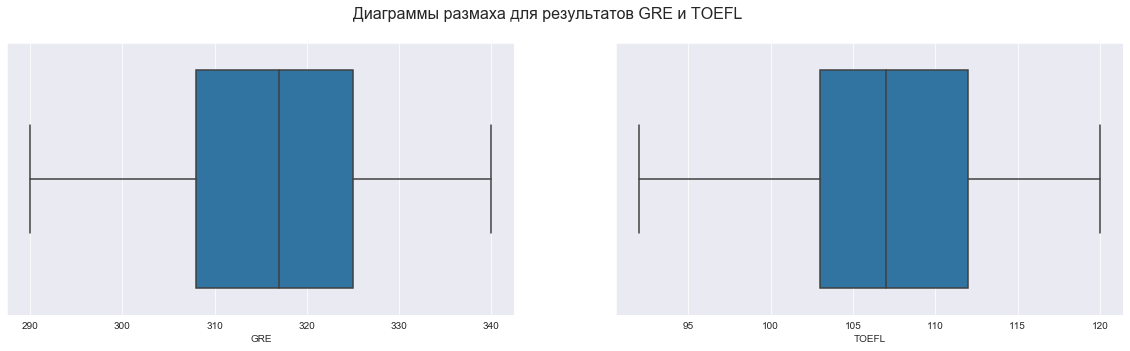

In [7]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
fig.suptitle('Диаграммы размаха для результатов GRE и TOEFL', fontsize = 16)
sns.boxplot(df['GRE'], ax = axes[0])
sns.boxplot(df['TOEFL'], ax = axes[1])
plt.show()

В данных о результатах GRE и TOEFL аномальных значений нет. 

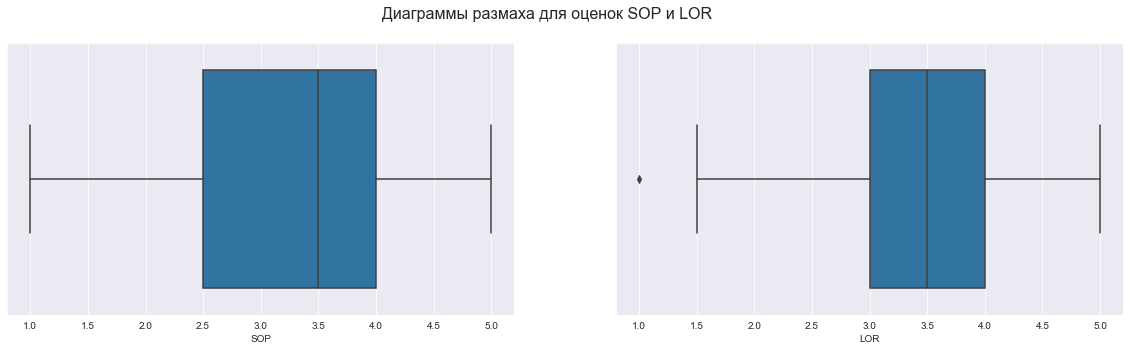

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
fig.suptitle('Диаграммы размаха для оценок SOP и LOR', fontsize = 16)
sns.boxplot(df['SOP'], ax = axes[0])
sns.boxplot(df['LOR'], ax = axes[1])
plt.show()

Данные об оценках мотивационного и рекомендательного писем также корректны.

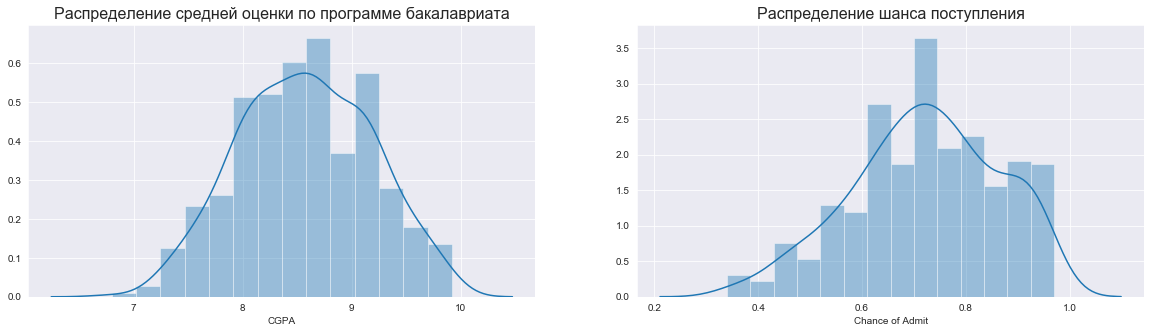

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
sns.distplot(df['CGPA'], ax = axes[0])
sns.distplot(df['Chance of Admit'], ax = axes[1])
axes[0].set_title('Распределение средней оценки по программе бакалавриата', fontsize = 16)
axes[1].set_title('Распределение шанса поступления', fontsize = 16)
plt.show()

В столбцах **CGPA** и **Chance of Admit** также нет некорректных данных.

In [10]:
df['University Rating'].describe()

count    500.000000
mean       3.114000
std        1.143512
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: University Rating, dtype: float64

Значения рейтинга университета соответствуют пятибалльной шкале.

In [11]:
df['Research'].unique()

array([1, 0], dtype=int64)

В бинарной переменной встречаются только два значения.

Данные корректны, можно переходить к решению задачи прогнозирования.

### Подвыборки.

Исходную выборку необходимо разделить на обучающую, валидационную и отложенную тестовую. Валидационную выборку будем использовать для подбора лучших параметров модели, тестовую используем один раз для финальной оценки качества.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X, y = df.drop(['Chance of Admit'], axis = 1), df['Chance of Admit'] # Отделяем предикторы от целевой переменной

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 12345)

In [15]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 12345)

Таким образом, обучающая выборка составляет 60% всех данных, тестовая и валидационная - по 20%.

### Выбор модели.

Импортируем инструменты для оценки модели:

In [16]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score

Начнём с простейшего - линейной регрессии.

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
model = LinearRegression()

In [19]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Оценим качество модели:

In [20]:
predictions = pd.DataFrame(model.predict(X_valid), index = y_valid.index)

In [21]:
print('RMSE: {:.5f}\nMAE: {:.5f}'.format(np.power(mse(y_valid, predictions), 0.5), mae(y_valid, predictions)))

RMSE: 0.06334
MAE: 0.04677


В среднем, модель ошибается на 4.68%. Сравним её с моделью, дающее среднее в качестве предсказания: 

$$ R_2 = 1 - \frac{MSE_0}{MSE_1}, $$ где $MSE_0$ - средняя квадратичная ошибка модели, $MSE_1$ - средняя квадратичная ошибка среднего.


In [22]:
print('Коэффициент детерминации R2 равен {:.5f}'.format(r2_score(y_valid, predictions)))

Коэффициент детерминации R2 равен 0.76816


Модель выдерживает проверку на адекватность - работает значительно лучше среднего.

Попробуем другую модель - случайный лес.

In [23]:
from sklearn.ensemble import RandomForestRegressor

Сделаем перебор параметров максимальной глубины дерева, используя по 100 деревьев в модели. Затем обучим 1500 деревьев на лучшей максимальной глубине.

In [24]:
best_depth = None
best_mae = 999999999
for depth in range(1, 36):
    model2 = RandomForestRegressor(n_estimators = 100, random_state = 12345, max_depth = depth)
    model2.fit(X_train, y_train)
    preds2 = model2.predict(X_valid)
    abs_error = mae(y_valid, preds2)
    if depth % 5 == 0:
        print('Глубина {}'.format(depth))
        print('RMSE: {:.5f}\nMAE: {:.5f}'.format(np.power(mse(y_valid, preds2), 0.5), abs_error))
        print('--------')
    if abs_error < best_mae:
        best_mae = abs_error
        best_depth = depth
print('Лучшая максимальная глубина - {}'.format(best_depth))

Глубина 5
RMSE: 0.06237
MAE: 0.04532
--------
Глубина 10
RMSE: 0.06331
MAE: 0.04556
--------
Глубина 15
RMSE: 0.06336
MAE: 0.04571
--------
Глубина 20
RMSE: 0.06343
MAE: 0.04570
--------
Глубина 25
RMSE: 0.06343
MAE: 0.04570
--------
Глубина 30
RMSE: 0.06343
MAE: 0.04570
--------
Глубина 35
RMSE: 0.06343
MAE: 0.04570
--------
Лучшая максимальная глубина - 6


Обучим итоговую модель:

In [25]:
model2 = RandomForestRegressor(n_estimators = 1500, random_state = 12345, max_depth = 6)

In [26]:
model2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1500, n_jobs=None, oob_score=False,
                      random_state=12345, verbose=0, warm_start=False)

In [27]:
preds2 = model2.predict(X_valid)

In [28]:
print('RMSE: {:.5f}\nMAE: {:.5f}'.format(np.power(mse(y_valid, preds2), 0.5), mae(y_valid, preds2)))

RMSE: 0.06250
MAE: 0.04519


In [29]:
print('Коэффициент детерминации R2 равен {:.5f}'.format(r2_score(y_valid, preds2)))

Коэффициент детерминации R2 равен 0.77428


Модель случайного леса работает чуть лучше линейной регрессии. Используем её в качестве финальной, проверим качество на отложенной выборке.

### Проверка качества.

In [30]:
preds_final = model2.predict(X_test)

In [31]:
print('RMSE: {:.5f}\nMAE: {:.5f}'.format(np.power(mse(y_test, preds_final), 0.5), mae(y_test, preds_final)))

RMSE: 0.06818
MAE: 0.04636


In [32]:
print('Коэффициент детерминации R2 равен {:.5f}'.format(r2_score(y_test, preds_final)))

Коэффициент детерминации R2 равен 0.74849


Получили модель, которая предсказывает шанс поступления в университет, в среднем ошибаясь на 4.6%. Я считаю это неплохим результатом.